# CrowdTruth for Binary Choice Tasks: Person Identification in Video

In this tutorial, we will apply CrowdTruth metrics to a **binary choice** crowdsourcing task for **Person Identification** in **video fragments**. The workers were asked to watch a short video fragment of about 3-5 seconds and then decide whether there is any *person* that appears in the video fragment. The task was executed on [FigureEight](https://www.figure-eight.com/). For more crowdsourcing annotation task examples, click [here](https://raw.githubusercontent.com/CrowdTruth-core/tutorial/getting_started.md).

To replicate this experiment, the code used to design and implement this crowdsourcing annotation template is available here: [template](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Binary/template.html), [css](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Binary/template.css), [javascript](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/People-Video-Binary/template.js). 

This is a screenshot of the task as it appeared to workers:

![Task Template](img/person-video-binary.png)

A sample dataset for this task is available in [this file](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/data/person-video-binary-choice.csv), containing raw output from the crowd on FigureEight. Download the file and place it in a folder named `data` that has the same root as this notebook. Now you can check your data:

In [1]:
import pandas as pd

test_data = pd.read_csv("data/person-video-binary-choice.csv")
test_data.head()

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,...,description,descriptiontags,hiddeninput_gold,imagelocation,imagetags,keyframeid_gold,selected_answer_gold,subtitles,subtitletags,videolocation
0,1856505106,8/15/2018 09:40:20,3974554217,8/15/2018 09:40:08,False,instagc,1.0,39127197,GBR,F7,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
1,1856505106,8/15/2018 10:06:28,3974582705,8/15/2018 10:06:15,False,keeprewarding,1.0,44637936,CAN,NS,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
2,1856505106,8/15/2018 10:26:51,3974605856,8/15/2018 10:26:32,False,fusioncash,1.0,5861591,USA,OH,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
3,1856505106,8/15/2018 10:28:32,3974607881,8/15/2018 10:27:41,False,prodege,1.0,40421145,GBR,F8,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
4,1856505106,8/15/2018 10:34:42,3974614913,8/15/2018 10:34:22,False,elite,1.0,43605496,GBR,I6,...,NaN,NaN,NaN,https://joran.org/ct/entity.admin.unit.2649/85...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Person Identification task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is a list containing `true` and `false` values
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

The complete configuration class is declared below:

In [3]:
class TestConfig(DefaultConfig):
    inputColumns = ["videolocation", "subtitles", "imagetags", "subtitletags"]
    outputColumns = ["selected_answer"]
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = ["yes", "no"]
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [4]:
data, config = crowdtruth.load(
    file = "data/person-video-binary-choice.csv",
    config = TestConfig()
)

data['judgments'].head()

,output.selected_answer,output.selected_answer.count,output.selected_answer.unique,submitted,started,worker,unit,duration,job
judgment,,,,,,,,,
3974554217,"{u'yes': 1, u'no': 0}",1,2,2018-08-15 09:40:20,2018-08-15 09:40:08,39127197,1856505106,12,data/person-video-binary-choice
3974582705,"{u'yes': 1, u'no': 0}",1,2,2018-08-15 10:06:28,2018-08-15 10:06:15,44637936,1856505106,13,data/person-video-binary-choice
3974605856,"{u'yes': 1, u'no': 0}",1,2,2018-08-15 10:26:51,2018-08-15 10:26:32,5861591,1856505106,19,data/person-video-binary-choice
3974607881,"{u'yes': 1, u'no': 0}",1,2,2018-08-15 10:28:32,2018-08-15 10:27:41,40421145,1856505106,51,data/person-video-binary-choice
3974614913,"{u'yes': 1, u'no': 0}",1,2,2018-08-15 10:34:42,2018-08-15 10:34:22,43605496,1856505106,20,data/person-video-binary-choice


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [5]:
results = crowdtruth.run(data, config)

`results` is a dict object that contains the quality metrics for the video fragments, annotations and crowd workers.

The **video fragment metrics** are stored in `results["units"]`:

In [6]:
results["units"].head()

,duration,input.imagetags,input.subtitles,input.subtitletags,input.videolocation,job,output.selected_answer,output.selected_answer.annotations,output.selected_answer.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,
1856505106,28.95,industry__c0_###_grinder__c1_###_production__c...,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-binary-choice,"{u'yes': 20, u'no': 0}",20,1,20,1.0,"{u'yes': 1.0, u'no': 0.0}",1.0,"{u'yes': 1.0, u'no': 0.0}"
1856505107,13.55,man__c0_###_soccer__c1_###_portrait__c2_###_pe...,this phenomena is it's massive the,phenomena__0_###_massive__1_###_,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-binary-choice,"{u'yes': 20, u'no': 0}",20,1,20,1.0,"{u'yes': 1.0, u'no': 0.0}",1.0,"{u'yes': 1.0, u'no': 0.0}"
1856505108,22.70,people__c0_###_man__c1_###_adult__c2_###_portr...,around could the lights be coming from,lights__0_###_coming__1_###_,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-binary-choice,"{u'yes': 20, u'no': 0}",20,1,20,1.0,"{u'yes': 1.0, u'no': 0.0}",1.0,"{u'yes': 1.0, u'no': 0.0}"
1856505109,29.65,water__c0_###_no person__c1_###_ocean__c2_###_...,when investigators map the coordinates onto lo...,investigators__0_###_map__1_###_coordinates__2...,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-binary-choice,"{u'yes': 0, u'no': 20}",20,1,20,1.0,"{u'yes': 0.0, u'no': 1.0}",1.0,"{u'yes': 0.0, u'no': 1.0}"
1856505110,25.30,sky__c0_###_no person__c1_###_power__c2_###_el...,the bright lights are part of a,bright lights__0_###_,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-binary-choice,"{u'yes': 0, u'no': 20}",20,1,20,1.0,"{u'yes': 0.0, u'no': 1.0}",1.0,"{u'yes': 0.0, u'no': 1.0}"


The `uqs` column in `results["units"]` contains the **video fragment quality scores**, capturing the overall workers agreement over each video fragment. Here we plot its histogram:

Text(0,0.5,u'Video Fragment')

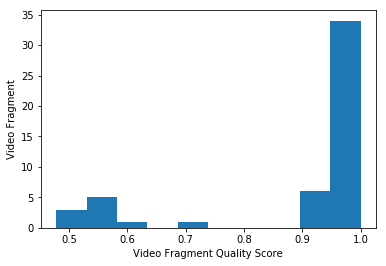

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results["units"]["uqs"])
plt.xlabel("Video Fragment Quality Score")
plt.ylabel("Video Fragment")

The `unit_annotation_score` column in `results["units"]` contains the **video fragment-annotation scores**, capturing the likelihood that an annotation is expressed in a video fragment. For each video fragment, we store a dictionary mapping each annotation to its video fragment-relation score.

In [8]:
results["units"]["unit_annotation_score"].head()

unit
1856505106    {u'yes': 1.0, u'no': 0.0}
1856505107    {u'yes': 1.0, u'no': 0.0}
1856505108    {u'yes': 1.0, u'no': 0.0}
1856505109    {u'yes': 0.0, u'no': 1.0}
1856505110    {u'yes': 0.0, u'no': 1.0}
Name: unit_annotation_score, dtype: object

The **worker metrics** are stored in `results["workers"]`:

In [9]:
results["workers"].head()

,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
5861591,16.76,1,25,25,0.923567,0.945869,0.976421,0.883719,0.917895,0.962767
6330997,17.90,1,50,50,0.870467,0.922869,0.943218,0.798106,0.877895,0.909114
6432269,19.54,1,50,50,0.922940,0.947020,0.974573,0.874202,0.913684,0.956787
11063039,31.66,1,50,50,0.885953,0.930025,0.952612,0.819831,0.888421,0.922795
13900808,23.82,1,50,50,0.928645,0.949371,0.978168,0.883827,0.917895,0.962885


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.

Text(0,0.5,u'Workers')

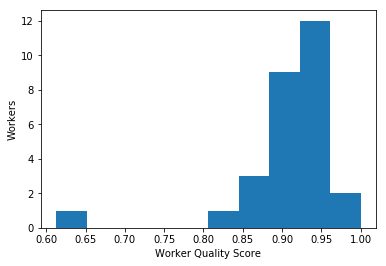

In [10]:
plt.hist(results["workers"]["wqs"])
plt.xlabel("Worker Quality Score")
plt.ylabel("Workers")

The **annotation metrics** are stored in `results["annotations"]`. The `aqs` column contains the **annotation quality scores**, capturing the overall worker agreement over one relation.

In [11]:
results["annotations"]

,output.selected_answer,aqs,aqs_initial
no,1000,0.925695,0.890105
yes,1000,0.953446,0.925473
